In [ ]:
#pip install -U scikit-learn

In [1]:
import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import seaborn as sns

from tqdm import tqdm

import shutil

In [7]:
import kagglehub

# Download latest version
DATASET_PATH = kagglehub.dataset_download("alexattia/the-simpsons-characters-dataset")

/Users/andrejalekseevic/PycharmProjects/neuralNetworksNSU2025/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 128
NUM_CLASS = 13

EPOCHS = 50

device = torch.device('cuda')

TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15

In [8]:
import os
import pandas

input_dir = DATASET_PATH + "/simpsons_dataset"

character_counts = {}

data = []

for character_folder in os.listdir(input_dir):
    character_folder_path = os.path.join(input_dir, character_folder)

    if os.path.isdir(character_folder_path):
        num_files = len([f for f in os.listdir(character_folder_path) if os.path.isfile(os.path.join(character_folder_path, f))])
        character_counts[character_folder] = num_files

    for character_folder in os.listdir(input_dir):
        character_folder_path = os.path.join(input_dir, character_folder)
        if os.path.isdir(character_folder_path):
            for filename in os.listdir(character_folder_path):
                file_path = os.path.join(character_folder_path, filename)
                if os.path.isfile(file_path):
                    data.append([character_folder, file_path])

df = pandas.DataFrame(data, columns=["character_folder", "filename"])

In [13]:
allowed_classes = []

sorted_counts = list(sorted(character_counts.items(), key=lambda x: -x[1]))
for character, count in sorted_counts:
    print(f"{character}: {count} images")
    allowed_classes.append(character)

allowed_classes = allowed_classes[:NUM_CLASS]

homer_simpson: 2246 images
ned_flanders: 1454 images
moe_szyslak: 1452 images
lisa_simpson: 1354 images
bart_simpson: 1342 images
marge_simpson: 1291 images
krusty_the_clown: 1206 images
principal_skinner: 1194 images
charles_montgomery_burns: 1193 images
milhouse_van_houten: 1079 images
chief_wiggum: 986 images
abraham_grampa_simpson: 913 images
sideshow_bob: 877 images
apu_nahasapeemapetilon: 623 images
kent_brockman: 498 images
comic_book_guy: 469 images
edna_krabappel: 457 images
nelson_muntz: 358 images
lenny_leonard: 310 images
mayor_quimby: 246 images
waylon_smithers: 181 images
maggie_simpson: 128 images
groundskeeper_willie: 121 images
barney_gumble: 106 images
selma_bouvier: 103 images
carl_carlson: 98 images
ralph_wiggum: 89 images
patty_bouvier: 72 images
martin_prince: 71 images
professor_john_frink: 65 images
snake_jailbird: 55 images
cletus_spuckler: 47 images
rainier_wolfcastle: 45 images
agnes_skinner: 42 images
sideshow_mel: 40 images
otto_mann: 32 images
fat_tony: 27

In [6]:
df[:5]

,character_folder,filename
0,cletus_spuckler,/root/.cache/kagglehub/datasets/alexattia/the-...
1,cletus_spuckler,/root/.cache/kagglehub/datasets/alexattia/the-...
2,cletus_spuckler,/root/.cache/kagglehub/datasets/alexattia/the-...
3,cletus_spuckler,/root/.cache/kagglehub/datasets/alexattia/the-...
4,cletus_spuckler,/root/.cache/kagglehub/datasets/alexattia/the-...


In [7]:
class_weights = {}
max_samples = max(character_counts[class_name] for class_name in allowed_classes)

for idx, class_name in enumerate(allowed_classes):
    weight = max_samples / character_counts[class_name]
    class_weights[idx] = weight

for idx, class_name in enumerate(allowed_classes):
    print(f"{class_name}: {class_weights[idx]:.2f} (Number of images: {character_counts[class_name]})")

homer_simpson: 1.00 (Number of images: 2246)
ned_flanders: 1.54 (Number of images: 1454)
moe_szyslak: 1.55 (Number of images: 1452)
lisa_simpson: 1.66 (Number of images: 1354)
bart_simpson: 1.67 (Number of images: 1342)
marge_simpson: 1.74 (Number of images: 1291)
krusty_the_clown: 1.86 (Number of images: 1206)
principal_skinner: 1.88 (Number of images: 1194)
charles_montgomery_burns: 1.88 (Number of images: 1193)
milhouse_van_houten: 2.08 (Number of images: 1079)
chief_wiggum: 2.28 (Number of images: 986)
abraham_grampa_simpson: 2.46 (Number of images: 913)
sideshow_bob: 2.56 (Number of images: 877)


In [22]:
output_dir = "./dataset_filtered"

os.makedirs(output_dir, exist_ok=True)
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for class_name in allowed_classes:
    class_path = os.path.join(input_dir, class_name)
    all_images = sorted(os.listdir(class_path))
    train_files, temp_files = train_test_split(all_images, train_size=TRAIN_SIZE, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=TEST_SIZE / (1 - TRAIN_SIZE), random_state=42)

    for subset, subset_files in zip(['train', 'val', 'test'], [train_files, val_files, test_files]):
        subset_class_dir = os.path.join(output_dir, subset, class_name)
        os.makedirs(subset_class_dir, exist_ok=True)

        for file_name in subset_files:
            src_file = os.path.join(class_path, file_name)
            dst_file = os.path.join(subset_class_dir, file_name)
            shutil.copy(src_file, dst_file)

    print(f"Processing completed for '{class_name}'.")

In [23]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


train_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
validation_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [34]:
from collections import Counter
import numpy as np

# train_dataset.targets — это список меток классов для всех изображений
class_counts = Counter(train_dataset.targets)

# Отобразим названия классов
for idx, class_name in enumerate(train_dataset.classes):
    print(f"{class_name}: {class_counts[idx]}")


abraham_grampa_simpson: 639
bart_simpson: 939
charles_montgomery_burns: 835
chief_wiggum: 690
homer_simpson: 1572
krusty_the_clown: 844
lisa_simpson: 947
marge_simpson: 903
milhouse_van_houten: 755
moe_szyslak: 1016
ned_flanders: 1017
principal_skinner: 835
sideshow_bob: 613


In [35]:
from collections import Counter
import numpy as np

# train_dataset.targets — это список меток классов для всех изображений
class_counts = Counter(validation_dataset.targets)

# Отобразим названия классов
for idx, class_name in enumerate(train_dataset.classes):
    print(f"{class_name}: {class_counts[idx]}")


abraham_grampa_simpson: 137
bart_simpson: 201
charles_montgomery_burns: 179
chief_wiggum: 148
homer_simpson: 337
krusty_the_clown: 181
lisa_simpson: 203
marge_simpson: 194
milhouse_van_houten: 162
moe_szyslak: 218
ned_flanders: 218
principal_skinner: 179
sideshow_bob: 132


In [14]:
class SimpsonClassifierCNNNet(nn.Module):
    def __init__(self):
        super().__init__()

        # --- Conv
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)

        # --- Batchnorm
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(512)
        self.bn6 = nn.BatchNorm2d(1024)
        self.bnfc = nn.BatchNorm1d(576)

        # --- Activation
        self.relu = nn.ReLU()

        # --- Xaxpool
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        # --- FC
        self.fc1 = nn.Linear(1024, 576)
        self.fc2 = nn.Linear(576, len(allowed_classes))

        # --- Dropout
        self.dropout = nn.Dropout(0.2)
        self.dropoutfc = nn.Dropout(0.5)


    def forward(self, x):
        # --- conv1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x)

        # --- conv2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x)

        # --- conv3
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x)

        # --- conv4
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x)

        # --- conv5
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x)

        # --- conv6
        x = self.conv6(x)
        x = self.bn6(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x)

        # --- flatten
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)

        # --- classification
        x = self.fc1(x)
        x = self.relu(x)
        x = self.bnfc(x)
        x = self.dropoutfc(x)

        x = self.fc2(x)

        return x


In [15]:
model = SimpsonClassifierCNNNet()
model.to(device)

SimpsonClassifierCNNNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn6): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [13]:
weights_tensor = torch.tensor([class_weights[idx] for idx in range(len(allowed_classes))], dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=weights_tensor)

In [14]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [15]:
metrics_df = pandas.DataFrame(columns=["Epoch", "Train Loss", "Train Accuracy", "Val Loss", "Val Accuracy"])

In [17]:
import torch
from sklearn.metrics import f1_score
import pandas as pd
from tqdm import tqdm

best_f1 = 0.0
best_acc = 0.0

for epoch in range(EPOCHS):
    # --- train
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    all_preds_train = []
    all_labels_train = []

    loop = tqdm(train_loader, desc=f"Эпоха {epoch+1}/{EPOCHS}")

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        all_preds_train.extend(predicted.cpu().numpy())
        all_labels_train.extend(labels.cpu().numpy())

        train_loss = running_loss / (loop.n + 1)
        train_acc = correct / total

        loop.set_description(f"Эпоха {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

    f1_train = f1_score(all_labels_train, all_preds_train, average="weighted")

    # --- validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    all_preds_val = []
    all_labels_val = []

    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

            all_preds_val.extend(predicted.cpu().numpy())
            all_labels_val.extend(labels.cpu().numpy())

    val_loss /= len(validation_loader)
    val_acc = val_correct / val_total
    f1_val = f1_score(all_labels_val, all_preds_val, average="weighted")

    scheduler.step(f1_val)
    # --- сохранение метрик
    new_row = pd.DataFrame([{
        "Epoch": epoch + 1,
        "Train Loss": train_loss,
        "Train Accuracy": train_acc,
        "Train F1": f1_train,
        "Val Loss": val_loss,
        "Val Accuracy": val_acc,
        "Val F1": f1_val
    }])
    metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

    # --- сохранение моделей
    torch.save(model.state_dict(), "last_model.pth")

    if f1_val > best_f1:
        best_f1 = f1_val
        torch.save(model.state_dict(), "best_f1_model.pth")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_acc_model.pth")

    print(f"Эпоха {epoch+1}: Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}, F1 = {f1_val:.4f}")


Эпоха 1/50, Train Loss: 1.3524, Train Acc: 0.5479: 100%|██████████| 91/91 [02:25<00:00,  1.59s/it]
<ipython-input-17-387af858b3e9>:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)


Эпоха 1: Val Loss = 1.1160, Val Acc = 0.6360, F1 = 0.6033


Эпоха 2/50, Train Loss: 0.9229, Train Acc: 0.6806: 100%|██████████| 91/91 [02:21<00:00,  1.56s/it]


Эпоха 2: Val Loss = 0.9167, Val Acc = 0.6971, F1 = 0.6889


Эпоха 3/50, Train Loss: 0.7062, Train Acc: 0.7613: 100%|██████████| 91/91 [02:20<00:00,  1.55s/it]


Эпоха 3: Val Loss = 0.6329, Val Acc = 0.8067, F1 = 0.7989


Эпоха 4/50, Train Loss: 0.5798, Train Acc: 0.8083: 100%|██████████| 91/91 [02:20<00:00,  1.54s/it]


Эпоха 4: Val Loss = 0.5395, Val Acc = 0.8337, F1 = 0.8281


Эпоха 5/50, Train Loss: 0.5075, Train Acc: 0.8335: 100%|██████████| 91/91 [02:19<00:00,  1.54s/it]


Эпоха 5: Val Loss = 0.5241, Val Acc = 0.8313, F1 = 0.8288


Эпоха 6/50, Train Loss: 0.4344, Train Acc: 0.8572: 100%|██████████| 91/91 [02:20<00:00,  1.54s/it]


Эпоха 6: Val Loss = 0.5419, Val Acc = 0.8429, F1 = 0.8448


Эпоха 7/50, Train Loss: 0.3928, Train Acc: 0.8725: 100%|██████████| 91/91 [02:21<00:00,  1.55s/it]


Эпоха 7: Val Loss = 0.5925, Val Acc = 0.8144, F1 = 0.8132


Эпоха 8/50, Train Loss: 0.3207, Train Acc: 0.8937: 100%|██████████| 91/91 [02:20<00:00,  1.54s/it]


Эпоха 8: Val Loss = 0.3656, Val Acc = 0.8871, F1 = 0.8865


Эпоха 9/50, Train Loss: 0.3083, Train Acc: 0.9004: 100%|██████████| 91/91 [02:20<00:00,  1.54s/it]


Эпоха 9: Val Loss = 0.3358, Val Acc = 0.9032, F1 = 0.9040


Эпоха 10/50, Train Loss: 0.2785, Train Acc: 0.9075: 100%|██████████| 91/91 [02:20<00:00,  1.54s/it]


Эпоха 10: Val Loss = 0.3225, Val Acc = 0.9036, F1 = 0.9022


Эпоха 11/50, Train Loss: 0.2459, Train Acc: 0.9185: 100%|██████████| 91/91 [02:19<00:00,  1.54s/it]


Эпоха 11: Val Loss = 0.2621, Val Acc = 0.9257, F1 = 0.9261


Эпоха 12/50, Train Loss: 0.2322, Train Acc: 0.9224: 100%|██████████| 91/91 [02:20<00:00,  1.54s/it]


Эпоха 12: Val Loss = 0.4125, Val Acc = 0.8827, F1 = 0.8830


Эпоха 13/50, Train Loss: 0.2144, Train Acc: 0.9290: 100%|██████████| 91/91 [02:19<00:00,  1.54s/it]


Эпоха 13: Val Loss = 0.2331, Val Acc = 0.9385, F1 = 0.9382


Эпоха 14/50, Train Loss: 0.1926, Train Acc: 0.9368: 100%|██████████| 91/91 [02:19<00:00,  1.53s/it]


Эпоха 14: Val Loss = 0.2634, Val Acc = 0.9317, F1 = 0.9312


Эпоха 15/50, Train Loss: 0.1843, Train Acc: 0.9400: 100%|██████████| 91/91 [02:19<00:00,  1.53s/it]


Эпоха 15: Val Loss = 0.2899, Val Acc = 0.9104, F1 = 0.9102


Эпоха 16/50, Train Loss: 0.1639, Train Acc: 0.9457: 100%|██████████| 91/91 [02:19<00:00,  1.53s/it]


Эпоха 16: Val Loss = 0.2279, Val Acc = 0.9333, F1 = 0.9355


Эпоха 17/50, Train Loss: 0.1113, Train Acc: 0.9650: 100%|██████████| 91/91 [02:19<00:00,  1.53s/it]


Эпоха 17: Val Loss = 0.1581, Val Acc = 0.9562, F1 = 0.9563


Эпоха 18/50, Train Loss: 0.0888, Train Acc: 0.9735: 100%|██████████| 91/91 [02:19<00:00,  1.53s/it]


Эпоха 18: Val Loss = 0.1600, Val Acc = 0.9590, F1 = 0.9591


Эпоха 19/50, Train Loss: 0.0919, Train Acc: 0.9713: 100%|██████████| 91/91 [02:18<00:00,  1.53s/it]


Эпоха 19: Val Loss = 0.1765, Val Acc = 0.9502, F1 = 0.9506


Эпоха 20/50, Train Loss: 0.0810, Train Acc: 0.9742: 100%|██████████| 91/91 [02:19<00:00,  1.54s/it]


Эпоха 20: Val Loss = 0.1445, Val Acc = 0.9614, F1 = 0.9615


Эпоха 21/50, Train Loss: 0.0769, Train Acc: 0.9735: 100%|██████████| 91/91 [02:18<00:00,  1.52s/it]


Эпоха 21: Val Loss = 0.1881, Val Acc = 0.9522, F1 = 0.9520


Эпоха 22/50, Train Loss: 0.0835, Train Acc: 0.9728:  91%|█████████ | 83/91 [02:08<00:12,  1.55s/it]


KeyboardInterrupt: 

In [18]:
metrics_df.to_csv("model.csv", index=False)
torch.save(model.state_dict(), 'model.pth')


In [16]:
model.load_state_dict(torch.load('best_f1_model.pth', map_location=device))
model.eval()

SimpsonClassifierCNNNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn6): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine

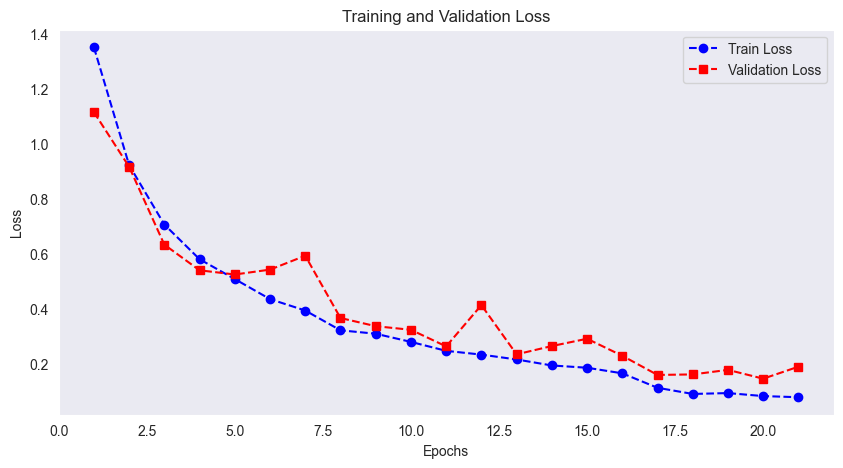

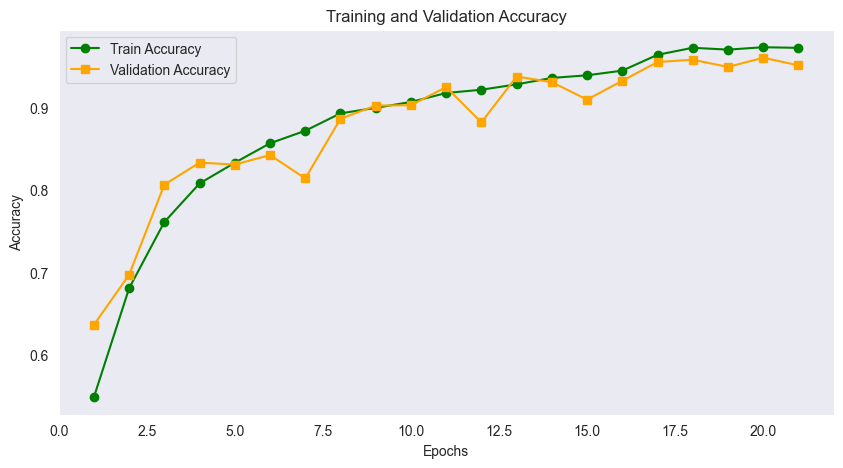

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = "model.csv"
df = pd.read_csv(file_path)

epochs = df["Epoch"]
train_loss = df["Train Loss"]
train_acc = df["Train Accuracy"]
val_loss = df["Val Loss"]
val_acc = df["Val Accuracy"]

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label="Train Loss", color='blue', linestyle='dashed', marker='o')
plt.plot(epochs, val_loss, label="Validation Loss", color='red', linestyle='dashed', marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

# Построение графиков точности
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, label="Train Accuracy", color='green', linestyle='solid', marker='o')
plt.plot(epochs, val_acc, label="Validation Accuracy", color='orange', linestyle='solid', marker='s')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

In [24]:
import numpy as np

y_true = []
y_pred = []

for batch_images, batch_labels in tqdm(test_loader):
    batch_images = batch_images.to(device)
    batch_predictions = model(batch_images)
    batch_pred_labels = np.argmax(batch_predictions.detach().cpu().numpy(), axis=1)

    y_true.extend(batch_labels.detach().cpu().numpy())
    y_pred.extend(batch_pred_labels)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


In [36]:
from collections import Counter
import numpy as np

# train_dataset.targets — это список меток классов для всех изображений
class_counts = Counter(test_dataset.targets)

# Отобразим названия классов
for idx, class_name in enumerate(train_dataset.classes):
    print(f"{class_name}: {class_counts[idx]}")


abraham_grampa_simpson: 137
bart_simpson: 202
charles_montgomery_burns: 179
chief_wiggum: 148
homer_simpson: 337
krusty_the_clown: 181
lisa_simpson: 204
marge_simpson: 194
milhouse_van_houten: 162
moe_szyslak: 218
ned_flanders: 219
principal_skinner: 180
sideshow_bob: 132



                           precision    recall  f1-score   support

           homer simpson      0.902     0.942     0.921       137
            ned flanders      0.903     0.970     0.936       202
             moe szyslak      0.960     0.939     0.949       179
            lisa simpson      0.971     0.899     0.933       148
            bart simpson      0.958     0.953     0.955       337
           marge simpson      0.978     0.989     0.984       181
        krusty the clown      0.935     0.917     0.926       204
       principal skinner      0.949     0.964     0.957       194
charles montgomery burns      0.981     0.975     0.978       162
     milhouse van houten      0.917     0.968     0.942       218
            chief wiggum      0.991     0.963     0.977       219
  abraham grampa simpson      0.988     0.933     0.960       180
            sideshow bob      0.962     0.962     0.962       132

                accuracy                          0.953      2493
      

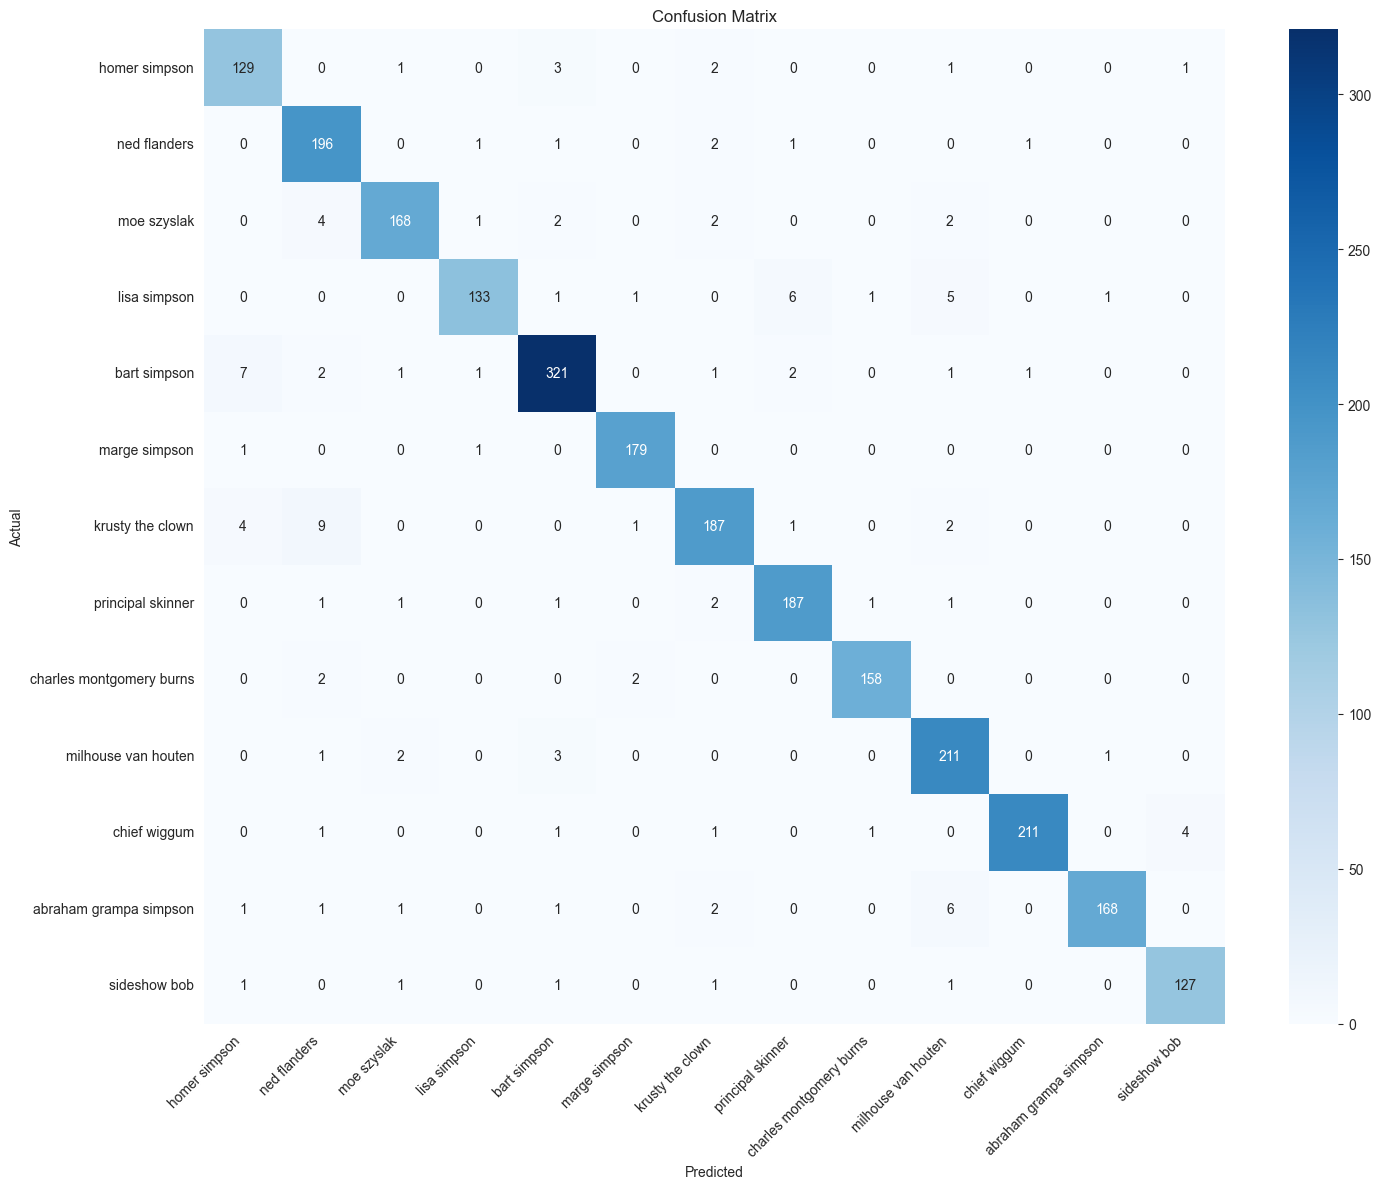

In [38]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Классификационный отчёт
print('\n', classification_report(
    y_true,
    y_pred,
    target_names=[name.replace('_', ' ') for name in allowed_classes],
    digits=3
))

# --- Матрица ошибок
plt.figure(figsize=(15, 12))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=[name.replace('_', ' ') for name in allowed_classes],
            yticklabels=[name.replace('_', ' ') for name in allowed_classes])

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [26]:
num_classes = len(np.unique(y_true))  # Определяем количество классов
class_accuracies = {}

for cls in range(num_classes):
    cls_mask = (y_true == cls)
    class_accuracies[cls] = accuracy_score(y_true[cls_mask], y_pred[cls_mask])

for cls, acc in class_accuracies.items():
    print(f"Class {allowed_classes[cls]}: Accuracy = {acc:.4f}")

Class homer_simpson: Accuracy = 0.9416
Class ned_flanders: Accuracy = 0.9703
Class moe_szyslak: Accuracy = 0.9385
Class lisa_simpson: Accuracy = 0.8986
Class bart_simpson: Accuracy = 0.9525
Class marge_simpson: Accuracy = 0.9890
Class krusty_the_clown: Accuracy = 0.9167
Class principal_skinner: Accuracy = 0.9639
Class charles_montgomery_burns: Accuracy = 0.9753
Class milhouse_van_houten: Accuracy = 0.9679
Class chief_wiggum: Accuracy = 0.9635
Class abraham_grampa_simpson: Accuracy = 0.9333
Class sideshow_bob: Accuracy = 0.9621
